In [1]:
import os
os.chdir('components/mechanisms')
os.system('rm nrnmech.dll')
print(os.system('nrnivmodl .')) # compile modfiles. Return 0 for success, other # for failure.
os.chdir('../../')
# This bit of code removes the network folder. Sometimes when changing parameters it is necessary to remove this
# in order to see the correct changes you made in this notebook. 

import sys
import shutil
import numpy as np
newpath = r'./network' 
if os.path.exists(newpath):
    try:
        shutil.rmtree(newpath)
        print("Removed Network Folder")
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

0
Removed Network Folder


In [2]:
import numpy as np
import logging

# We now create the nodes needed for the PING network
from bmtk.builder.networks import NetworkBuilder


n_I = 10 # number WB inhibitory cells
n_E = 40 # number of RTM excitatory cells

net = NetworkBuilder('network')

net.add_nodes(N=n_I, pop_name='Inh',     # N = number of inhibitory cells
        model_type='biophysical',
        model_template='hoc:WBInhCell',  # WBInhCell hoc definition
        morphology='blank.swc')

net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

In [3]:
Area=1*3.1416*1.492 *1e-8 

net.add_edges(source={'pop_name': 'Exc'}, target={'pop_name': 'Inh'},
            connection_rule=1,
            dynamics_params='PING_ExcToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999],
            delay=0,
            target_sections=['soma'],
            syn_weight=1)

In [4]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [5]:
#Change these values to modify the current clamp properties
IbarE=0.5
sigmaE=0
IbarI=0
sigmaI=0

# The I_bars need to be modified because the units involved in Borger's book and bmtk are not the same.
#uA/cm2 [units of Borger's] * 1000 * cm2 --> nA [units of NEURON]
IbarE=IbarE*1000*Area
sigmaE=sigmaE*1000*Area
IbarI=IbarI*1000*Area
sigmaI=sigmaI*1000*Area

#Calculating the respective conductance necessary to input the current specified above
#Ohm's law: gbar=I/(erev-V_init=-65)    erev=0 for the synapses specified in PING_Edrive.json and PING_Idrive.json
#gbar units = uS , Voltage units = mV, Current units = nA
V_init=-65
meanE=IbarE/(-V_init)
stdevE=sigmaE/(-V_init)
meanI=IbarI/(-V_init)
stdevI=sigmaI/(-V_init)

def target_ind_equals_source_ind(source, target, offset=0, min_syn=1,max_syn=1):
    if source['node_id']+offset==target['node_id']:
        return 1
    return 0


def rand_syn_weight(source, target, mean, stdev):
    sec_x=0.5
    sec_id=0
    return np.random.normal(mean,stdev), sec_x, sec_id

In [6]:
from bmtk.builder.networks import NetworkBuilder

Edrive = NetworkBuilder('Edrive')
Edrive.add_nodes(n_E,pop_name='Evirt', potential='exc', model_type='virtual')

connE=Edrive.add_edges(source=Edrive.nodes(), target=net.nodes(pop_name='Exc'),
            connection_rule=target_ind_equals_source_ind,
            connection_params={'offset':n_I},
            dynamics_params='PING_Edrive.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            target_sections=['soma'],
            delay=0
            )

connE.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'mean': meanE, 'stdev': stdevE},
                    dtypes=[float, float, np.uint])

Edrive.build()
Edrive.save_nodes(output_dir='network')
Edrive.save_edges(output_dir='network')

In [7]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='Edrive')
for i in range(n_E):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/EDrive.h5')

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

sim_len = 200.0
dt = 0.1

build_env_bionet(base_dir='.',
                 network_dir='network',
                 report_vars=['v'],
                 spikes_inputs=[('Edrive', 'input/EDrive.h5')],
                                #('Idrive', 'input/IDrive.h5')],#,('extnet','input/ext_inp_poisson.h5')],
                 v_init=V_init,
                 tstop=sim_len, dt=dt,
                 config_file='config.json'
                )

In [9]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-06-01 12:54:31,759 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-06-01 12:54:31,862 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-06-01 12:54:31,928 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-06-01 12:54:32,768 [INFO] Building virtual cell stimulations for Edrive_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for Edrive_spikes


2021-06-01 12:54:32,935 [INFO] Running simulation for 200.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 200.000 ms with the time step 0.100 ms


2021-06-01 12:54:32,937 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-06-01 12:54:32,940 [INFO] Block save every 2000 steps


INFO:NEURONIOUtils:Block save every 2000 steps


2021-06-01 12:54:34,892 [INFO]     step:2000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:2000 t_sim:200.00 ms


2021-06-01 12:54:34,910 [INFO] Simulation completed in 1.975 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.975 seconds 


## 4. Analyzing results

Results of the simulation, as specified in the config, are saved into the output directory. 

In [10]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'Exc'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
node1=0
v_trace1=report.data(population='network', node_id=node1)
node2=11
v_trace2=report.data(population='network', node_id=node2)
time = np.arange(report.tstart(population='network'), report.tstop(population='network'), report.dt(population='network'))

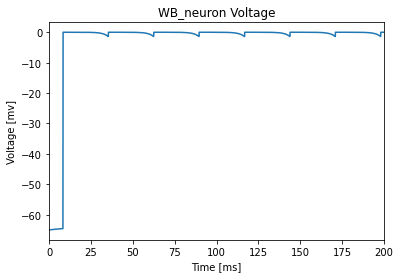

In [11]:
import matplotlib.pyplot as plt
plt.plot(time, v_trace1)
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('WB_neuron Voltage')
plt.xlim([0,200])
#plt.plot(time, v_trace2)
plt.show()

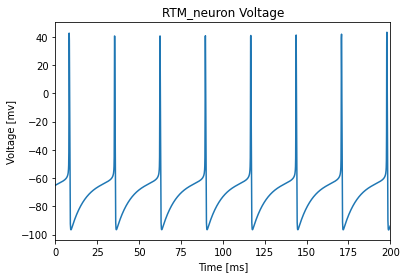

In [12]:
import matplotlib.pyplot as plt
plt.plot(time, v_trace2)
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('RTM_neuron Voltage')
plt.xlim([0,200])
plt.show()

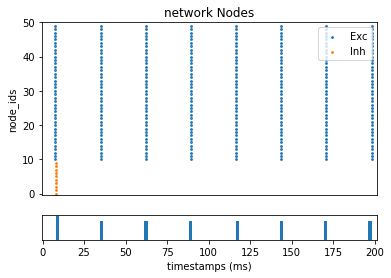

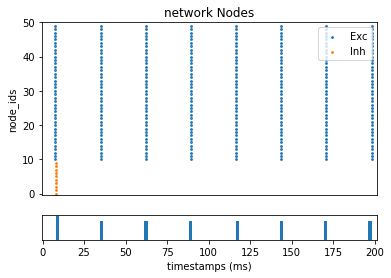

In [13]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='config.json', group_by='pop_name')

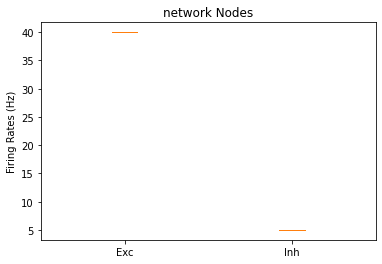

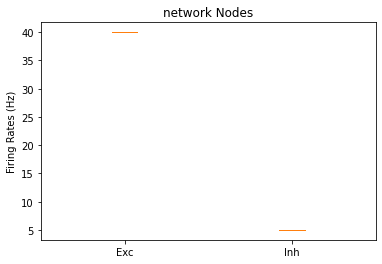

In [14]:
plot_rates_boxplot(config_file='config.json', group_by='pop_name')

In [15]:
pip freeze

anyio==3.1.0
argon2-cffi==20.1.0
async-generator==1.10
attrs==21.2.0
Babel==2.9.1
backcall==0.2.0
bleach==3.3.0
bmtk==0.0.8
cached-property==1.5.2
certifi==2021.5.30
cffi==1.14.5
chardet==4.0.0
contextvars==2.4
cycler==0.10.0
dataclasses==0.8
decorator==4.4.2
defusedxml==0.7.1
entrypoints==0.3
h5py==2.10.0
idna==3.2
imageio==2.9.0
immutables==0.15
importlib-metadata==4.2.0
ipykernel==5.5.5
ipython==7.16.1
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==3.0.1
json5==0.9.5
jsonschema==3.2.0
jupyter-client==6.1.12
jupyter-core==4.7.1
jupyter-server==1.8.0
jupyterlab==3.0.16
jupyterlab-pygments==0.1.2
jupyterlab-server==2.5.2
kiwisolver==1.3.1
MarkupSafe==2.0.1
matplotlib==3.3.4
mistune==0.8.4
mpmath==1.2.1
nbclassic==0.3.1
nbclient==0.5.3
nbconvert==6.0.7
nbformat==5.1.3
nest-asyncio==1.5.1
networkx==2.5.1
NEURON==8.0.0
notebook==6.4.0
numpy==1.19.5
packaging==20.9
pandas==0.23.0
pandocfilters==1.4.3
parso==0.8.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.2.0
prometheus-client==0.10.1
promp

In [17]:
from platform import python_version
print(python_version())

3.6.13
